In [42]:
import random 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict,namedtuple
import gym
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys

In [27]:
env=gym.make('Blackjack-v0')

In [28]:

"""
This is a OffPolicy implementation of BlackJack game
"""

'\nThis is a OffPolicy implementation of BlackJack game\n'

In [29]:
player_sum=list(np.arange(4,22))
dealer_card=list(np.arange(1,11))
usable_ace=[True,False]
action_space=list(np.arange(2))
target_policy={}


In [30]:
"""
Random environment test
"""

for  i in range(3):
    state=env.reset()
    while True:
        print(state)
        action=env.action_space.sample()
        state,reward,done,info=env.step(action)
        if done:
            print("the reward obtained is ",reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(9, 5, False)
the reward obtained is  -1.0
You lost :(

(10, 6, False)
the reward obtained is  -1.0
You lost :(

(20, 10, False)
the reward obtained is  -1.0
You lost :(



In [31]:
# behaviour policy used for generating random exploration behaviour
def behaviour_policy():
    prob=random.uniform(0,1)
    if prob>0.5:
        return 0
    else:
        return 1

In [32]:
# function for generating the episode
def get_episodes(env,Q):
    episode=[]
    state=env.reset()
    while True:
        action=behaviour_policy()
        next_state,reward,done,info=env.step(action)
        episode.append((state,action,reward))
        state=next_state
        if done:
            break
    return episode

    
    

In [37]:
def offpolicyMonteCarloControl(env,Q,C,num_iters=500000,gamma=1.0):
    #initialisation
    state=[]
    for i in player_sum:
        for j in dealer_card:
            for k in usable_ace:
                state.append((i,j,k))
                maximum=-1
                for a in action_space:
                    Q[(i,j,k)][a]=np.random.random()
                    if Q[(i,j,k)][a]>maximum:
                        maximum=Q[(i,j,k)][a]
                        greedy_action=a
                    C[(i,j,k)][a] = 0 
                target_policy[(i,j,k)] = greedy_action  
    #off policy control using off policy weighted importance sampling
    for i in range(num_iters):
        episode=get_episodes(env,Q)
        G=0
        W=1
        state,action,rewards=zip(*episode)
        for t in range(len(episode)):
            G=gamma*G+rewards[-1-t]
            C[state[-1-t]][action[-1-t]]=C[state[-1-t]][action[-1-t]]+W
            Q[state[-1-t]][action[-1-t]]=Q[state[-1-t]][action[-1-t]]+W*(G-Q[state[-1-t]][action[-1-t]])/(C[state[-1-t]][action[-1-t]])
            maximum=-1
            for a in action_space:
                if Q[state[-1-t]][a]>maximum:
                    maximum=Q[state[-1-t]][a]
                    best_action=a
            target_policy[state[-1-t]]=best_action
            if action[-1-t]!=target_policy[state[-1-t]]:
                break
            W=W*(1/0.5)
    return Q,target_policy
    
                    
            
        
        
    
    
    
    

In [38]:
"""
plot functions used from Udacity reinforcement Learning
"""

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()


In [39]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

In [40]:
nA=env.action_space.n
Q=defaultdict(lambda:np.zeros(nA))
C=defaultdict(lambda:np.zeros(nA))
(Q,target_policy)=offpolicyMonteCarloControl(env,Q,C)


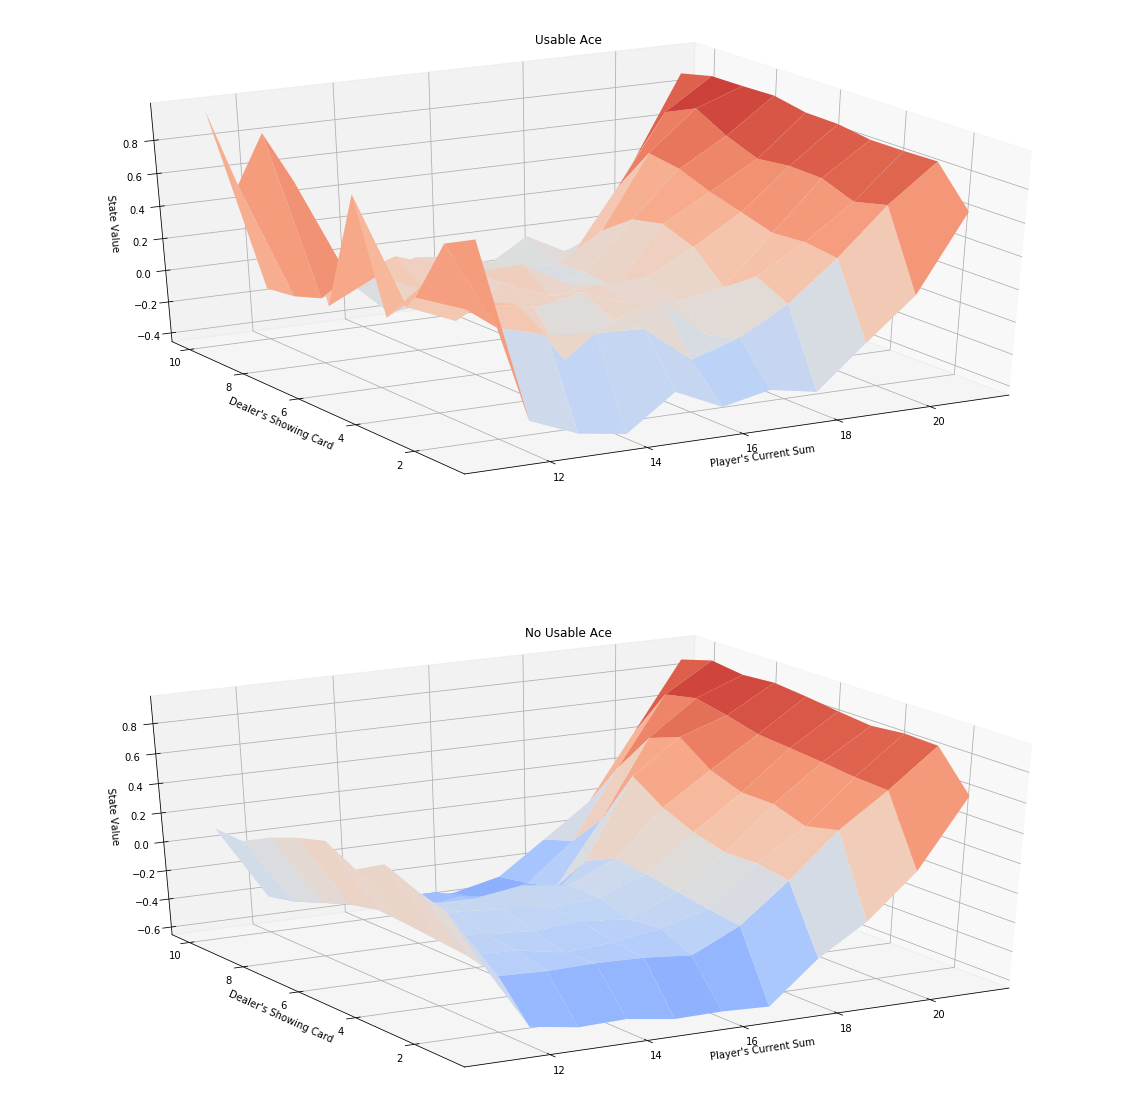

In [43]:
V = dict((k,np.max(v)) for k, v in Q.items())
plot_blackjack_values(V)


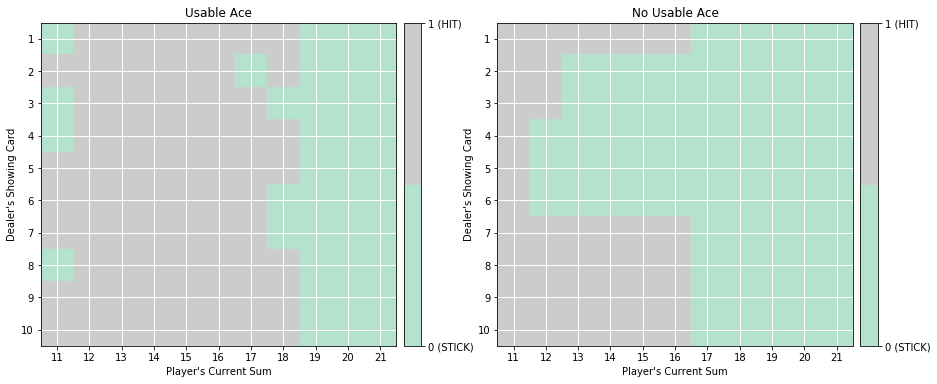

In [44]:
plot_policy(target_policy)

In [46]:
"""
Result:
 
we can find that with no usable ace the off-Policy algorithm performs very well and yields very good results

but we can find with usable ace case it yields proper output but has more Variance.


"""

'\nResult:\n \nwe can find that with no usable ace the off-Policy algorithm performs very well and yields very good results\n\nbut we can find with usable ace case it yields proper output but with some has more Variance.\n\n\n'